# Integrative Analysis

In [45]:
# imports
import os
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
%matplotlib inline

CELL_CHANGES = ["localization", "morphology"]
BIO_PLATE_MAP_BATCHES = ["2025_01_27_Batch_13"] ## "2024_01_23_Batch_7", "2024_12_09_Batch_11", "2025_03_17_Batch_15"
BIO_BATCHES = ["2025_01_Batch_13-14"] ## "2024_02_Batch_7-8", "2024_12_Batch_11-12", "2025_03_Batch_15-16"

# pl.Config.set_tbl_rows(20)  # Sets the number of rows displayed
# BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
# COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"

## 1. Loading variants and ClinVar annotations

### 1.1 Variant info

In [46]:
cave_allele_set = pl.read_csv("../../../inputs/3.explore_variants/2025-03-11_B13-14_CAVA_Genes.csv")
cave_allele_set = cave_allele_set.with_columns(
    pl.col("gene_allele")
    .str.replace_all(r"[^\w]", "")  # keep only letters, numbers, underscore
    .str.replace(r"_+$", "")        # remove trailing underscores
    .alias("gene_allele_cleaned")
)
cave_allele_set
cava_ref_var_alleles = cave_allele_set["gene_allele_cleaned"].unique().to_list()
# sorted(cava_ref_var_alleles)

In [47]:
profiled_variants_df, profiled_variants_pass_qc_df = pl.DataFrame(), pl.DataFrame()

for batch, batch_biorep in zip(BIO_PLATE_MAP_BATCHES, BIO_BATCHES):
    profiled_variants_df_batch = pl.DataFrame()
    platemap_dir = f"../../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{batch}/platemap"
    for platemap in os.listdir(platemap_dir):
        platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
        profiled_variants_df_batch = pl.concat([profiled_variants_df_batch, 
                                                platemap_df.filter(
                                                    (~pl.col("node_type").is_in(["TC","NC","PC"]))&\
                                                    (pl.col("node_type").is_not_null())&\
                                                    (pl.col("gene_allele").is_in(cava_ref_var_alleles))
                                                )], 
                                                how="diagonal_relaxed")
    
    ## load the img qc results
    allele_qc_df = pl.read_csv(f"../../../outputs/{batch_biorep}/well-level_img_qc_gfp_sum.csv")
    # Step 1: Filter only rows with PASS
    allele_qc_df_pass = allele_qc_df.filter(pl.col("QC_Flag")=="PASS")
    # Step 2: Group by gene_allele and Batch, count occurrences
    df_grouped = allele_qc_df_pass.select([
        pl.col("gene_allele"),
        pl.col("Batch"),
        pl.col("QC_Flag")
    ]).unique()
    # Step 3: Pivot to wide format
    df_pivot = df_grouped.pivot(
        values="QC_Flag",
        index="gene_allele",
        on="Batch"
    )
    # Step 4: Filter alleles with PASS in both batches
    # (They will have non-null values in both columns)
    # Step 4: Build filter expression dynamically for non-null in all batches
    batches = allele_qc_df_pass.select("Batch").unique().get_column("Batch").to_list()
    # Step 4: Dynamically build filter expression to check non-null in all batches
    filter_expr = reduce(
        operator.and_,
        [pl.col(batch).is_not_null() for batch in batches]
    )
    # Step 5: Apply filter to get only alleles with PASS in all batches
    df_result = df_pivot.filter(filter_expr)
    # print(df_result)
    profiled_variants_pass_qc_df_batch = profiled_variants_df_batch.filter(
        (pl.col("gene_allele").is_in(df_result["gene_allele"]))
    )

    profiled_variants_df = pl.concat([profiled_variants_df, profiled_variants_df_batch], 
                                      how="diagonal_relaxed")
    profiled_variants_pass_qc_df = pl.concat([profiled_variants_pass_qc_df, profiled_variants_pass_qc_df_batch], 
                                      how="diagonal_relaxed")
        
profiled_variants_df = profiled_variants_df.drop(["allele_set", "imaging_plate", "batch1", "batch2", "clone_ID", "hgmd_ID"])
profiled_variants_pass_qc_df = profiled_variants_pass_qc_df.drop(["allele_set", "imaging_plate", "batch1", "batch2", "clone_ID", "hgmd_ID"])

In [48]:
# profiled_variants_df["node_type"].unique()
## All variants have a reference, yeah!
# [gene for gene in profiled_variants_pass_qc_df["gene_allele"].str.split("_").list.get(0) if gene not in profiled_variants_pass_qc_df["symbol"].unique()]

In [49]:
print(profiled_variants_df.unique(subset="gene_allele").filter((pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol"))).shape)
print(profiled_variants_pass_qc_df.unique(subset="gene_allele").filter((pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol"))).shape)

print(profiled_variants_df.unique(subset="symbol").shape)
print(profiled_variants_pass_qc_df.unique(subset="symbol").shape)

(409, 23)
(396, 23)
(27, 23)
(27, 23)


In [50]:
396 / 409#, 336 / 349

0.9682151589242054

In [51]:
change_sum_local, change_sum_morph = pl.DataFrame(), pl.DataFrame()
change_wtvar = {}

for bio_batch in BIO_BATCHES:
    change_sum_local_batch = pl.read_csv(f"../../../outputs/{bio_batch}/altered_local_summary_auroc.csv")
    change_sum_morph_batch = pl.read_csv(f"../../../outputs/{bio_batch}/altered_morph_summary_auroc.csv")
    ## load the img qc results
    allele_qc_df = pl.read_csv(f"../../../outputs/{bio_batch}/well-level_img_qc_gfp_sum.csv")
    # Step 1: Filter only rows with PASS
    allele_qc_df_pass = allele_qc_df.filter(pl.col("QC_Flag")=="PASS")
    # Step 2: Group by gene_allele and Batch, count occurrences
    df_grouped = allele_qc_df_pass.select([
        pl.col("gene_allele"),
        pl.col("Batch"),
        pl.col("QC_Flag")
    ]).unique()
    # Step 3: Pivot to wide format
    df_pivot = df_grouped.pivot(
        values="QC_Flag",
        index="gene_allele",
        on="Batch"
    )
    # Step 4: Filter alleles with PASS in both batches
    # (They will have non-null values in both columns)
    # Step 4: Build filter expression dynamically for non-null in all batches
    batches = allele_qc_df_pass.select("Batch").unique().get_column("Batch").to_list()
    # Step 4: Dynamically build filter expression to check non-null in all batches
    filter_expr = reduce(
        operator.and_,
        [pl.col(batch).is_not_null() for batch in batches]
    )
    # Step 5: Apply filter to get only alleles with PASS in all batches
    df_result = df_pivot.filter(filter_expr)
    # print(df_result)
    change_sum_local_batch = change_sum_local_batch.filter(
        (pl.col("allele_0").is_in(df_result["gene_allele"]))&(pl.col("allele_0").is_in(cava_ref_var_alleles))
    )
    change_sum_morph_batch = change_sum_morph_batch.filter(
        (pl.col("allele_0").is_in(df_result["gene_allele"]))&(pl.col("allele_0").is_in(cava_ref_var_alleles))
    )
    change_sum_local = pl.concat([change_sum_local, change_sum_local_batch], how="diagonal_relaxed")
    change_sum_morph = pl.concat([change_sum_morph, change_sum_morph_batch], how="diagonal_relaxed")

change_wtvar["localization"] = change_sum_local
change_wtvar["morphology"] = change_sum_morph

In [53]:
# clin_var_scores = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/3_integrated_assay_results/1_inputs/ai_pred_struc_scores.tsv", 
#                          separator="\t", infer_schema_length=10000)
# clin_var_scores = clin_var_scores.with_columns(
#     pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("allele_0")
# )
# clin_var_scores.head()

clin_var_scores = pl.scan_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/4_compare_AI_scores/3_outputs/processed_data/dbnsfp/dbNSFP5.0a_variant.clin_var_re-annot_pdb_variants_plddt_rsa.parquet"
)
clin_var_scores = clin_var_scores.with_columns(
    pl.concat_str([pl.col("genename"), pl.col("clinvar_aa_change")], separator="_").alias("allele_0"),
    pl.col("clinvar_clnsig_clean").cast(pl.String).alias("clinvar_clnsig_clean_old")
).with_columns(
    pl.when(pl.col("clinvar_clnsig_clean_old")=="2_Benign")
    .then(pl.lit("4_Benign"))
    .when(pl.col("clinvar_clnsig_clean_old")=="4_VUS")
    .then(pl.lit("3_VUS"))
    .when(pl.col("clinvar_clnsig_clean_old")=="3_Conflicting")
    .then(pl.lit("2_Conflicting"))
    .otherwise(pl.col("clinvar_clnsig_clean_old"))
    .alias("clinvar_clnsig_clean")
)
clin_var_scores = clin_var_scores.filter(pl.col("allele_0").is_in(profiled_variants_pass_qc_df["gene_allele"])).collect()
# clin_var_scores.collect()
# clin_var_scores

clinvar_palette = sns.color_palette("Set2")
clinvar_palette[3], clinvar_palette[0] = clinvar_palette[0], clinvar_palette[3]

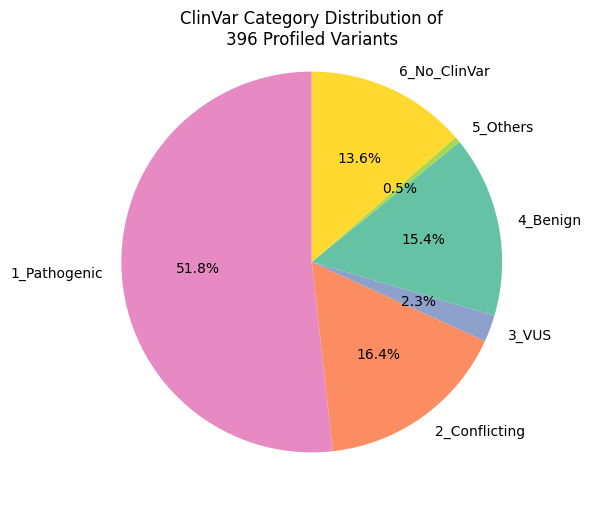

In [54]:
profiled_variants_df_clinvar = profiled_variants_pass_qc_df.join(
    clin_var_scores.select(
        pl.col(["allele_0","plddt","rsa","clinvar_clnsig_clean"])
    ), 
    left_on="gene_allele", right_on="allele_0", how="left"
).filter(
    (pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol")) 
).with_columns(
    pl.col("clinvar_clnsig_clean").fill_null("6_No_ClinVar")
).unique(subset="gene_allele") ## get the unique alleles only

df = profiled_variants_df_clinvar.to_pandas()
df["symbol"] = df["gene_allele"].apply(lambda x: x.split("_")[0])

# Count category frequencies
counts = df["clinvar_clnsig_clean"].value_counts()

# Sort categories if you want specific order
category_order = sorted(df["clinvar_clnsig_clean"].unique())
counts = counts.reindex([cat for cat in category_order if cat in counts.index])

# Plot pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=.6,    # how far the pct texts are from center (default 0.6)
    labeldistance=1.10,  # how far the slice labels are (default 1.1)
    colors=clinvar_palette
)
ax.set_title(f"ClinVar Category Distribution of\n{profiled_variants_df_clinvar.shape[0]} Profiled Variants",y=.94)
plt.tight_layout()
plt.show()

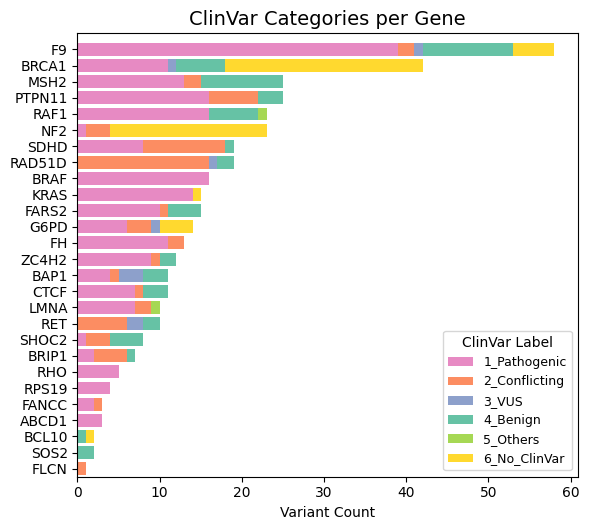

In [55]:
# 2. Count per (gene, category)
top_num = 40
counts = (
    df.groupby(["symbol", "clinvar_clnsig_clean"])
    .size()
    .reset_index(name="count")
)
# 3. Pivot
pivot = counts.pivot(index="symbol", columns="clinvar_clnsig_clean", values="count").fillna(0)

# Add total count column and sort by it (descending)
pivot["total_count"] = pivot.sum(axis=1)
pivot = pivot.sort_values("total_count", ascending=False).head(top_num)
pivot = pivot.drop(columns=["total_count"])

# 4. Ensure category order
for cat in category_order:
    if cat not in pivot.columns:
        pivot[cat] = 0
pivot = pivot[category_order]

# 5. Plotting
fig, ax = plt.subplots(figsize=(6, max(4, len(pivot)*0.2)))
# Get Set2 colors
colors = clinvar_palette
bottom = None
for cat, color in zip(category_order, colors):
    ax.barh(pivot.index, pivot[cat], left=bottom, label=cat, color=color)
    bottom = pivot[cat] if bottom is None else bottom + pivot[cat]
# Axis formatting
ax.set_xlabel("Variant Count")
ax.set_ylim(-1, pivot.shape[0] - .5)  # Tighten y-axis to remove top/bottom gaps
ax.set_title(f"ClinVar Categories per Gene", fontsize=14)
ax.invert_yaxis()
ax.legend(title="ClinVar Label", fontsize=9, title_fontsize=10, loc="lower right")
plt.tight_layout()
plt.show()

In [17]:
pl.Config.set_tbl_rows(20)  # Sets the number of rows displayed
change_wtvar["localization"].filter((pl.col("allele_0").str.contains("FARS2"))).sort(by="AUROC_Mean", descending=True) #(pl.col(f"Altered_local_both_batches"))
# change_wtvar["morphology"].filter(pl.col(f"Altered_morph_both_batches")).sort(by=["allele_0","AUROC_Mean"])

allele_0,Altered_local_batch13,Altered_local_batch14,Altered_local_both_batches,AUROC_batch13,AUROC_batch14,AUROC_Mean
str,i64,i64,bool,f64,f64,f64
"""FARS2_His84Pro""",0,1,false,0.887161,0.813692,0.850426
"""FARS2_Gly309Ser""",0,1,false,0.860268,0.815717,0.837993
"""FARS2_Ile388Ser""",0,0,false,0.784428,0.756129,0.770279
"""FARS2_Leu371Phe""",0,0,false,0.717496,0.682172,0.699834
"""FARS2_Thr246Met""",0,0,false,0.69202,0.664555,0.678287
"""FARS2_Gly3Val""",0,0,false,0.660354,0.655355,0.657854
"""FARS2_Arg419Cys""",0,0,false,0.629263,0.671303,0.650283
"""FARS2_Asp325Tyr""",0,0,false,0.654862,0.602295,0.628578
"""FARS2_Ile329Thr""",0,0,false,0.65082,0.602201,0.62651


In [18]:
12/396, 26/396

(0.030303030303030304, 0.06565656565656566)

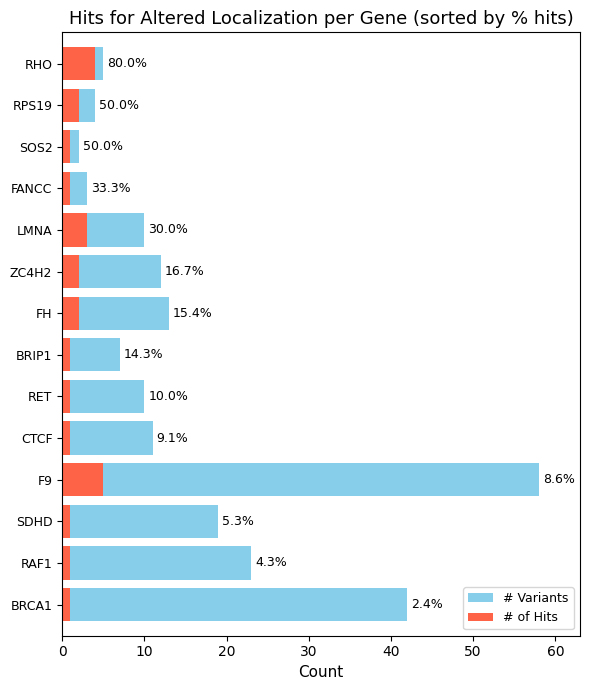

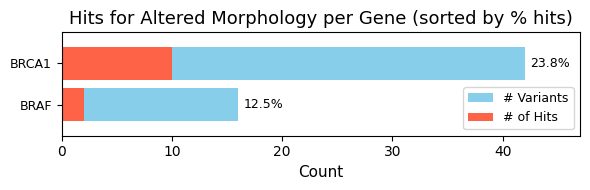

In [ ]:
# import plotly.express as px
# def interactive_gene_summary_barplot(df, cell_change):
#     df = df.copy()
#     df["pct_hits"] = df["len_hits"] / df["len"] * 100
#     df = df.sort_values(by=["len", "pct_hits"], ascending=False).reset_index(drop=True)

#     fig = px.bar(
#         df,
#         x="len",
#         y="by",
#         orientation="h",
#         color="len_hits",
#         hover_data=["len", "len_hits", "pct_hits"],
#         color_continuous_scale="RdBu",
#         labels={"by": "Gene", "len": "Total Variants", "len_hits": "Hits"},
#         title=f"Altered {cell_change.capitalize()} Hits per Gene (Interactive)"
#     )
#     fig.update_layout(
#         yaxis=dict(autorange="reversed"),
#         height=max(800, len(df)*10),
#         margin=dict(l=120, r=20, t=40, b=20),
#     )
#     fig.show()

def plot_gene_level_summary_horizontal(total_allele_hit_sum_df, cell_change):
    # 1. Fill nulls with 0
    total_allele_hit_sum_df["len_hits"] = total_allele_hit_sum_df["len_hits"].fillna(0).astype(int)

    # 2. Compute percentage of hits
    total_allele_hit_sum_df["pct_hits"] = (
        total_allele_hit_sum_df["len_hits"] / total_allele_hit_sum_df["len"] * 100
    )

    # 3. Sort by percentage descending
    total_allele_hit_sum_df = total_allele_hit_sum_df.sort_values(
        by=["pct_hits", "len"], ascending=False
    ).reset_index(drop=True)

    total_allele_hit_sum_df = total_allele_hit_sum_df[total_allele_hit_sum_df["pct_hits"]>0]

    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_height = 0.5
    fig_height = max(2, min(n_genes * bar_height, 30))  # cap to prevent overgrowth
    fig_width = 6
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Horizontal bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percent
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            va="center",
            ha="left",
            fontsize=9,
        )

    # Axis formatting
    ax.set_yticks(y)
    ax.set_xlim(None, max(total_allele_hit_sum_df["len"]+5))  # Tighten y-axis to remove top/bottom gaps
    ax.set_ylim(-.75, len(y)-.25)  # Tighten y-axis to remove top/bottom gaps
    ax.set_yticklabels(total_allele_hit_sum_df["by"], fontsize=9)
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"Hits for Altered {cell_change.capitalize()} per Gene (sorted by % hits)",
        fontsize=13
    )
    ax.invert_yaxis()  # Highest hit on top
    ax.legend(fontsize=9, loc="lower right")
    # Improve spacing
    plt.tight_layout()
    plt.show()


for cell_change in CELL_CHANGES:
    total_allele_hit_sum_df = profiled_variants_df_clinvar.filter(pl.col("node_type")=="allele").unique(subset="gene_allele").group_by(by="symbol").len().sort(by="len", descending=True).join(
        change_wtvar[cell_change].filter(pl.col(f"Altered_{cell_change[:5]}_both_batches")).with_columns(
            pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("symbol")
        ).group_by(by="symbol").len().sort(by="len", descending=True), on="by", suffix="_hits", how="left"
    ).to_pandas()
    plot_gene_level_summary_horizontal(total_allele_hit_sum_df, cell_change)

In [71]:
profiled_variants_df_clinvar.filter(pl.col("node_type")=="allele").join(
    change_wtvar["morphology"].filter(pl.col(f"Altered_morph_both_batches")).with_columns(
        pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("symbol")
    ), left_on="gene_allele", right_on="allele_0"
)["gene_allele", "clinvar_clnsig_clean"]

gene_allele,clinvar_clnsig_clean
str,str
"""BRCA1_Ser186Tyr""","""4_Benign"""
"""BRAF_Gly596Val""","""1_Pathogenic"""
"""BRCA1_Asn132Lys""","""4_Benign"""
"""BRCA1_His299Tyr""","""6_No_ClinVar"""
"""BRCA1_Pro510Ser""","""6_No_ClinVar"""
"""BRCA1_Thr581Ile""","""6_No_ClinVar"""
"""BRCA1_Met548Ile""","""6_No_ClinVar"""
"""BRCA1_His239Arg""","""4_Benign"""
"""BRAF_Val471Phe""","""1_Pathogenic"""


<Figure size 640x480 with 0 Axes>

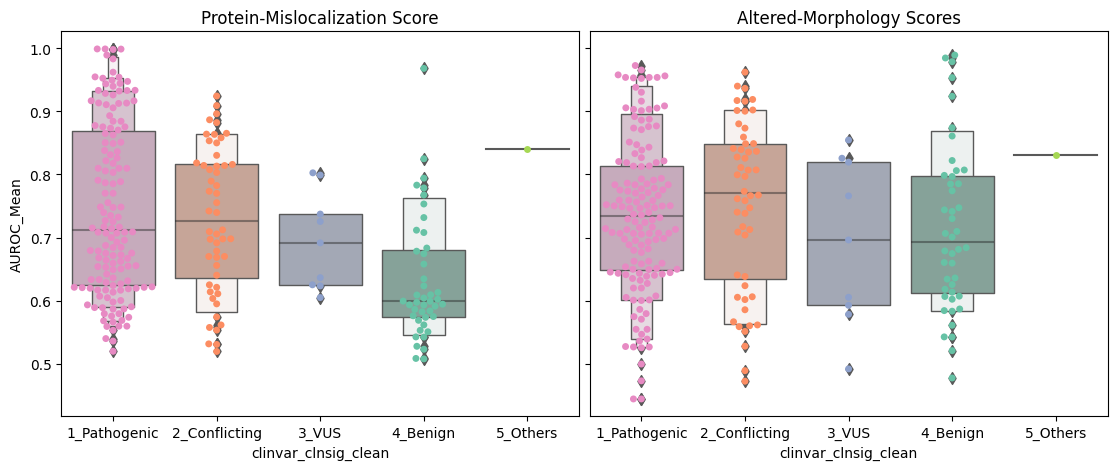

In [ ]:
plt.clf()
fig, axes = plt.subplots(1,2,figsize=(13.5,5),sharey=True)
sns.boxenplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").to_pandas(), x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.3, ax=axes[0],
              palette=clinvar_palette[:-1],
              order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").to_pandas()["clinvar_clnsig_clean"].unique()))
sns.swarmplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").to_pandas(), x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes[0],
              palette=clinvar_palette[:-1],
              order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").to_pandas()["clinvar_clnsig_clean"].unique()))
axes[0].set_title("Protein-Mislocalization Score")
sns.boxenplot(data=change_wtvar["morphology"].join(clin_var_scores, on="allele_0").to_pandas(), x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.3, ax=axes[1],
              palette=clinvar_palette[:-1],
              order=sorted(change_wtvar["morphology"].join(clin_var_scores, on="allele_0").to_pandas()["clinvar_clnsig_clean"].unique()))
sns.swarmplot(data=change_wtvar["morphology"].join(clin_var_scores, on="allele_0").to_pandas(), x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes[1],
              palette=clinvar_palette[:-1],
              order=sorted(change_wtvar["morphology"].join(clin_var_scores, on="allele_0").to_pandas()["clinvar_clnsig_clean"].unique()))
axes[1].set_title("Altered-Morphology Scores")
axes[1].set_ylabel("")
plt.subplots_adjust(wspace=.02)

## 2. Loading cell profiles

In [21]:
BATCH_LIST_DICT = {
    # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}

In [23]:
# Paths
pass_qc_prof_pq_path = "../../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
ref_var_cell_qc_profile_df = pl.DataFrame()

# Get meta features
for batch_id in BATCH_LIST_DICT.keys():
    batch_alleles = (
        pl.scan_parquet(
            pass_qc_prof_pq_path.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(profiled_variants_pass_qc_df["gene_allele"].unique()))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
        .select([
            "Metadata_CellID",
            "Metadata_gene_allele",
            "Metadata_Well",
            "Metadata_Plate",
            "Metadata_node_type"
        ])
    )
    ref_var_cell_qc_profile_df = pl.concat([ref_var_cell_qc_profile_df, batch_alleles.collect()])

In [24]:
# Paths
prof_pq_path = "../../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles.parquet"
ref_var_cell_all_profiles = []

# Get meta features
for batch_id in BATCH_LIST_DICT.keys():
    batch_alleles = (
        pl.scan_parquet(
            prof_pq_path.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(profiled_variants_pass_qc_df["gene_allele"].unique()))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
    )
    ref_var_cell_all_profiles.append(batch_alleles)
    
gfp_feats = [i for i in ref_var_cell_all_profiles[0].collect_schema() if "GFP" in i and "Brightfield" not in i]
gfp_feats = ["Metadata_CellID"] + gfp_feats

morph_feats = [i for i in ref_var_cell_all_profiles[0].collect_schema() if ("DNA" in i or "Mito" in i or "AGP" in i) and "Brightfield" not in i]
morph_feats = ["Metadata_CellID"] + morph_feats

ref_var_cell_all_gfp_profiles_df = pl.concat([batch_alleles.select(gfp_feats).collect() for batch_alleles in ref_var_cell_all_profiles])
# This method of joining ensures that only cells past filters are included in the abundance analysis
ref_var_cell_gfp_profile_df = ref_var_cell_qc_profile_df.join(ref_var_cell_all_gfp_profiles_df.select(gfp_feats), on="Metadata_CellID", how="left")

ref_var_cell_all_morph_profiles_df = pl.concat([batch_alleles.select(morph_feats).collect() for batch_alleles in ref_var_cell_all_profiles])
# This method of joining ensures that only cells past filters are included in the abundance analysis
ref_var_cell_morph_profile_df = ref_var_cell_qc_profile_df.join(ref_var_cell_all_morph_profiles_df.select(morph_feats), on="Metadata_CellID", how="left")

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def remove_corr_feats(df, corr_thres=.8):
    # 2. Identify numeric columns
    all_num_feats = [
        name
        for name, dtype in df.schema.items()
        if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
    ]
    # 3. Bring that slice into pandas
    pdf = df.select(all_num_feats).to_pandas()
    # 4. Compute absolute correlation matrix
    corr = pdf.corr().abs()
    # 5. Mask out the lower triangle (we only need one side)
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )
    # 6. Pick columns to drop: any column with correlation > threshold to *any* other
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thres)]
    # 7. Drop them in your original Polars DF
    df_drop_corr_cols = df.drop(to_drop)

    # colocal_col_cat = set(["_".join(col.split('_')[1:3]) for col in colocal_cols])
    # print(colocal_col_cat)
    # colocal_col_dict = defaultdict(list)
    # for col in colocal_cols:
    #     colocal_col_dict["_".join(col.split('_')[1:3])].append(col)
    # colocal_col_dict
    return df_drop_corr_cols


def plot_dr(df, dr_method, standardize=True, ax=None, dr_args={}, plot_args={}):
    df_val = df.select(pl.col([col for col in df.columns if not col.startswith("Metadata_")]))#.drop_nulls()
    if standardize:
        # Standardize the features before PCA
        scaler = StandardScaler()
        df_val = pd.DataFrame(scaler.fit_transform(df_val), columns=df_val.columns)

    if dr_method=="pca":
        pca = PCA(**dr_args) #n_components=10
        dr_result = pca.fit_transform(df_val)
    if dr_method=="umap":
        # Perform UMAP
        umap_model = umap.UMAP(**dr_args) ## n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1
        dr_result = umap_model.fit_transform(df_val.to_numpy())

    dr_res_df = pd.DataFrame(dr_result, columns=[f"Comp{i+1}" for i in range(dr_result.shape[1])])
    for key in ["hue", "style", "size"]:
        if key in plot_args and plot_args[key] in df.columns:
            dr_res_df[plot_args[key]] = df[plot_args[key]].to_numpy()

    if ax is None:
        # Plot UMAP
        fig, ax = plt.subplots(1, 1, figsize=(6, 7))

    # print(len(dr_res_df[plot_args["hue"]].unique()))
    sns.scatterplot(data=dr_res_df.sort_values(by=plot_args["hue"]), alpha=.5,
                    x="Comp1", y="Comp2",
                    palette=sns.color_palette("husl", len(dr_res_df.dropna(subset=plot_args["hue"])[plot_args["hue"]].unique())),#, 
                    s=40, ax=ax, **plot_args)
    # plt.show()
    # ax[1].legend(ncol=2, title="Metadata_Batch")
    return dr_res_df


ref_var_well_gfp_profile_df = (
    ref_var_cell_gfp_profile_df.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in ref_var_cell_gfp_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)

ref_var_well_gfp_profile_df = ref_var_well_gfp_profile_df.with_columns(
    pl.col("Metadata_Plate")
      # capture a “B” followed by any non-underscore chars up to the first “A”
      .str.extract(r"(B[^_]*?A)", 1)
      .alias("Metadata_Batch")
).drop_nulls()

ref_var_well_gfp_profile_df = remove_corr_feats(ref_var_well_gfp_profile_df)
ref_var_well_gfp_profile_df

Metadata_Plate,Metadata_Well,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,Cytoplasm_Correlation_K_AGP_GFP,Cytoplasm_Correlation_K_GFP_AGP,Cytoplasm_Correlation_Manders_AGP_GFP,Cytoplasm_Correlation_Manders_GFP_AGP,Cytoplasm_Correlation_Manders_GFP_DNA,Cytoplasm_Correlation_Manders_GFP_Mito,Cytoplasm_Correlation_Overlap_AGP_GFP,Cytoplasm_Correlation_Overlap_DNA_GFP,Cytoplasm_Correlation_RWC_GFP_AGP,Cytoplasm_Correlation_RWC_GFP_DNA,Cytoplasm_Granularity_10_GFP,Cytoplasm_Granularity_11_GFP,Cytoplasm_Granularity_12_GFP,Cytoplasm_Granularity_13_GFP,Cytoplasm_Granularity_14_GFP,Cytoplasm_Granularity_15_GFP,Cytoplasm_Granularity_16_GFP,Cytoplasm_Granularity_2_GFP,Cytoplasm_Granularity_6_GFP,Cytoplasm_Granularity_9_GFP,Cytoplasm_Intensity_MassDisplacement_GFP,Cytoplasm_Location_CenterMassIntensity_X_GFP,Cytoplasm_Location_CenterMassIntensity_Y_GFP,Cytoplasm_Location_CenterMassIntensity_Z_GFP,Cytoplasm_Location_MaxIntensity_Z_GFP,Cytoplasm_RadialDistribution_FracAtD_GFP_10of10,Cytoplasm_RadialDistribution_FracAtD_GFP_1of10,Cytoplasm_RadialDistribution_FracAtD_GFP_9of10,Cytoplasm_Texture_Correlation_GFP_10_00_256,Cells_Correlation_Manders_GFP_DNA,Cells_Location_CenterMassIntensity_Z_GFP,Cells_Location_MaxIntensity_Z_GFP,Cells_RadialDistribution_FracAtD_GFP_10of10,Cells_RadialDistribution_FracAtD_GFP_8of10,Cells_Texture_InfoMeas1_GFP_10_00_256,Nuclei_Correlation_Costes_AGP_GFP,Nuclei_Correlation_Costes_GFP_AGP,Nuclei_Correlation_Costes_GFP_DNA,Nuclei_Correlation_Costes_GFP_Mito,Nuclei_Correlation_Costes_Mito_GFP,Nuclei_Correlation_Manders_GFP_AGP,Nuclei_Correlation_Manders_GFP_DNA,Nuclei_Correlation_Manders_GFP_Mito,Nuclei_Correlation_Overlap_GFP_Mito,Nuclei_Correlation_RWC_GFP_AGP,Nuclei_Correlation_RWC_GFP_Mito,Nuclei_Location_CenterMassIntensity_Z_GFP,Nuclei_Location_MaxIntensity_Z_GFP,Nuclei_RadialDistribution_RadialCV_GFP_1of10,Nuclei_Texture_Contrast_GFP_20_00_256,Nuclei_Texture_Correlation_GFP_20_00_256,Metadata_Batch
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""2025_01_28_B14A7A8P1_T1""","""M21""","""BRCA1_His239Arg""",0.321336,0.186293,0.619311,1.0,1.0,1.0,0.999763,0.962247,1.0,0.214374,3.955305,1.0,0.989808,1.0,0.699686,0.921583,0.926847,0.728473,0.588105,1.207075,0.465719,0.017307,0.302933,0.050251,0.0,0.770533,1.536765,2.260879,0.559734,3.276841,605.475228,576.772818,0.0,0.0,0.41396,0.002654,0.246047,0.498533,0.441523,0.0,0.0,0.212886,0.164912,-0.058488,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.97188,0.778489,0.775938,0.0,0.0,0.037453,0.0,0.0,"""B14A"""
"""2025_01_28_B14A7A8P2_T3""","""O23""","""SDHD_Val111Ile""",-0.020226,0.211408,0.884737,0.969629,1.0,1.0,1.0,0.999739,1.0,0.739257,1.018125,0.286165,1.0,1.0,1.0,0.870686,0.882147,0.681429,0.313383,0.063577,0.070141,0.0,0.0,0.0,0.0,0.081536,11.818574,0.983973,0.198766,6.128637,516.639266,517.4891,0.0,0.0,0.41028,0.001937,0.250756,0.190616,0.878079,0.0,0.0,0.1388605,0.1616194,-0.027514,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.940646,0.705702,0.855368,0.0,0.0,0.053787,0.827821,0.0,"""B14A"""
"""2025_01_28_B14A7A8P1_T2""","""N15""","""KRAS_Gly13Asp""",0.235967,0.317439,0.569447,1.0,1.0,1.0,1.0,0.837808,1.0,0.322327,2.52052,0.984212,0.997029,1.0,0.736413,0.915254,0.934621,0.728901,0.516961,0.418625,0.063781,0.007726,0.0,0.033396,0.000002,0.609298,0.118113,1.782475,0.648068,3.962956,509.534214,571.046014,0.0,0.0,0.425612,0.002504,0.253795,0.489212,0.610374,0.0,0.0,0.181563,0.158405,-0.181754,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.946001,0.73368,0.707775,0.0,0.0,0.024416

## 3. Loading subcell compartment per gene

In [26]:
hpa_subcell_loc = pl.read_csv("/home/shenrunx/data_storage/igvf/varchamp/subcellular_localization/hpa_subcellular_location_annotations/subcellular_location_data.tsv", separator="\t")
hpa_subcell_loc = hpa_subcell_loc.with_columns(
    pl.when(pl.col("Main location").str.contains(";"))
    .then(pl.lit("Multiple"))
    .otherwise(pl.col("Main location"))
    .alias("Subcell_Loc")
)
hpa_subcell_loc_main = hpa_subcell_loc.filter(
    (pl.col("Subcell_Loc")!="Multiple")&(pl.col("Additional location").is_null()&(pl.col("Reliability")=="Approved"))
)

hpa_genes = hpa_subcell_loc["Gene name"]
# hpa_genes

# Read a JSON file into a pandas DataFrame
cd_code_json_file_path = "/home/shenrunx/data_storage/igvf/varchamp/subcellular_localization/cd-code/dataset.json"
cd_code_df = pd.read_json(cd_code_json_file_path)
# display(cd_code_df.head())
# 1. normalize into a new DataFrame
cell_compart_labels = pd.json_normalize(cd_code_df["labels"])#.dropna(how="all")
# display(cell_compart_labels)
## 2. drop the labels
cd_code_df = pd.concat([cd_code_df, cell_compart_labels], axis=1)
cd_code_df = cd_code_df.dropna(subset=["gene_names"]).drop(columns=["labels"])
cd_code_df = cd_code_df[cd_code_df["gene_names"]!=""]
cd_code_df.sort_values(by="gene_names")

,gene_names,entry,sequence,idrs,split,FCR_SUM,FCR_MEAN,NCPR_SUM,NCPR_MEAN,ISO,...,lysosome,rna_granule,endoplasmic_reticulum,vesicles,,nuclear_speckles,pbody,pml_body,post_synaptic_density,transcriptional
1829,A3G,U5KJ79_HUMAN,MKPHFRNTVERMYRDTFSYNFYNRPILSRRNTVWLCYEVKTKGPSR...,"[PLDA, CQK]",dev,94.428571,0.245908,5.857143e+00,1.525298e-02,8.31250,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1238,AAAS,AAAS_HUMAN,MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINLP...,"[CSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPP, DPLKTPGRL...",train,88.000000,0.161172,4.440892e-16,8.133502e-19,7.87500,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1272,AATF,AATF_HUMAN,MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGEDG...,[MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGED...,train,195.714286,0.349490,-3.771429e+01,-6.734694e-02,4.59375,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
64,ABCC5,MRP5_HUMAN,MKDIDIGKEYIIPSPGYRSVRERTSTSGTHRDREDSKFRRTRPLEC...,[DIDIGKEYIIPSPGYRSVRERTSTSGTHRDREDSKFRRTRPLECQ...,train,314.571429,0.218908,1.628571e+01,1.133313e-02,8.75000,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1275,ABI2,ABI2_HUMAN,MAELQMLLEEEIPGGRRALFDSYTNLERVADYCENNYIQSADKQRA...,"[QMLLE, RRALFDS, CENNYIQSADKQRALEETKAY, ASQLRR...",train,95.571429,0.186299,-5.571429e+00,-1.086048e-02,6.12500,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,ZWILCH,H3BSG1_HUMAN,MAHNPNMTHLKINLPVTALPPLWVRCDSSDPEGTCWLGAELITTNN...,[MAHNPNMTHLKI],train,14.000000,0.166667,2.000000e+00,2.380952e-02,8.75000,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
168,ZWINT,ZWINT_HUMAN,MEAAETEAEAAALEVLAEVAGILEPVGLQEEAELPAKILVEFVVDS...,"[MEAAETEAEAA, AQEDTAKGLDPLASEDTSRQKAIAAKEQWKEL...",train,82.714286,0.298608,-8.714286e+00,-3.145952e-02,4.81250,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
592,ZYX,ZYX_HUMAN,MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSEP...,[MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSE...,train,103.285714,0.180569,-6.714286e+00,-1.173826e-02,6.56250,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2547,dJ402G11.9,Q6ICA1_HUMAN,MYVPALGWEFLASTRLTSELNFLLQEIDNCYHRAAEGRAPKIEKQI...,"[EGRAPKIEKQIQSKGPGITEREKREIIENAEKEKSPEQNLFEK, ...",train,125.285714,0.230729,8.714286e+00,1.604841e-02,8.75000,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
ref_var_well_gfp_profile_hpa_df = ref_var_well_gfp_profile_df.join(
    hpa_subcell_loc_main.with_columns(
        pl.col("Gene name").alias("Metadata_genename_hpa"),
        pl.col("Subcell_Loc").alias("Metadata_Subcell_Loc"),
    ).select(pl.col(["Metadata_genename_hpa", "Metadata_Subcell_Loc"])), 
    left_on="Metadata_gene_allele", right_on="Metadata_genename_hpa",
    how="left"
)
# ref_var_well_gfp_profile_hpa_df.drop_nulls(subset="Metadata_Subcell_Loc")
# ref_allele_well_profile_df_hpa.filter(pl.col("Metadata_Plate").str.contains("B11"))

,Comp1,Comp2,Metadata_Batch
0,2.092563,-3.073457,B13A
1,7.503058,2.732521,B14A
2,5.060227,-1.894384,B13A
3,7.535163,0.775117,B13A
4,7.963840,-9.079372,B14A
...,...,...,...
3538,-7.028456,6.078228,B14A
3539,9.348144,16.015255,B13A
3540,9.724177,15.249067,B14A
3541,5.402078,12.327528,B14A


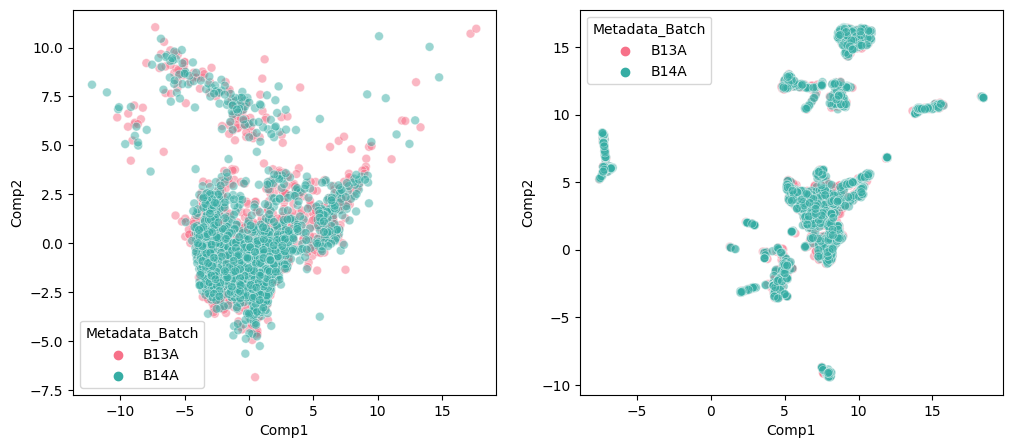

In [30]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
plot_dr(ref_var_well_gfp_profile_hpa_df, "pca", ax=axes[0], dr_args={"n_components": 10}, plot_args={"hue": "Metadata_Batch"})
# plot_dr(ref_allele_well_profile_df_hpa, "pca", dr_args={"n_components": 10}, plot_args={"hue": "Metadata_Subcell_Loc"})
plot_dr(ref_var_well_gfp_profile_hpa_df, "umap", ax=axes[1], 
        dr_args={"n_neighbors":15, "min_dist":0.1, "n_components":2, "random_state":42, "n_jobs":1}, 
        plot_args={"hue": "Metadata_Batch"})

In [27]:
ref_var_well_gfp_profile_hpa_values = ref_var_well_gfp_profile_hpa_df.select(pl.col([col for col in ref_var_well_gfp_profile_hpa_df.columns if not col.startswith("Metadata_")]))#.drop_nulls()
# Standardize the features before PCA
scaler = StandardScaler()
df_val = pd.DataFrame(scaler.fit_transform(ref_var_well_gfp_profile_hpa_values), columns=ref_var_well_gfp_profile_hpa_values.columns)

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1) ## 
dr_result = umap_model.fit_transform(df_val.to_numpy())
dr_res_df = pd.DataFrame(dr_result, columns=[f"Comp{i+1}" for i in range(dr_result.shape[1])])
dr_res_df["allele"] = ref_var_well_gfp_profile_hpa_df["Metadata_gene_allele"]

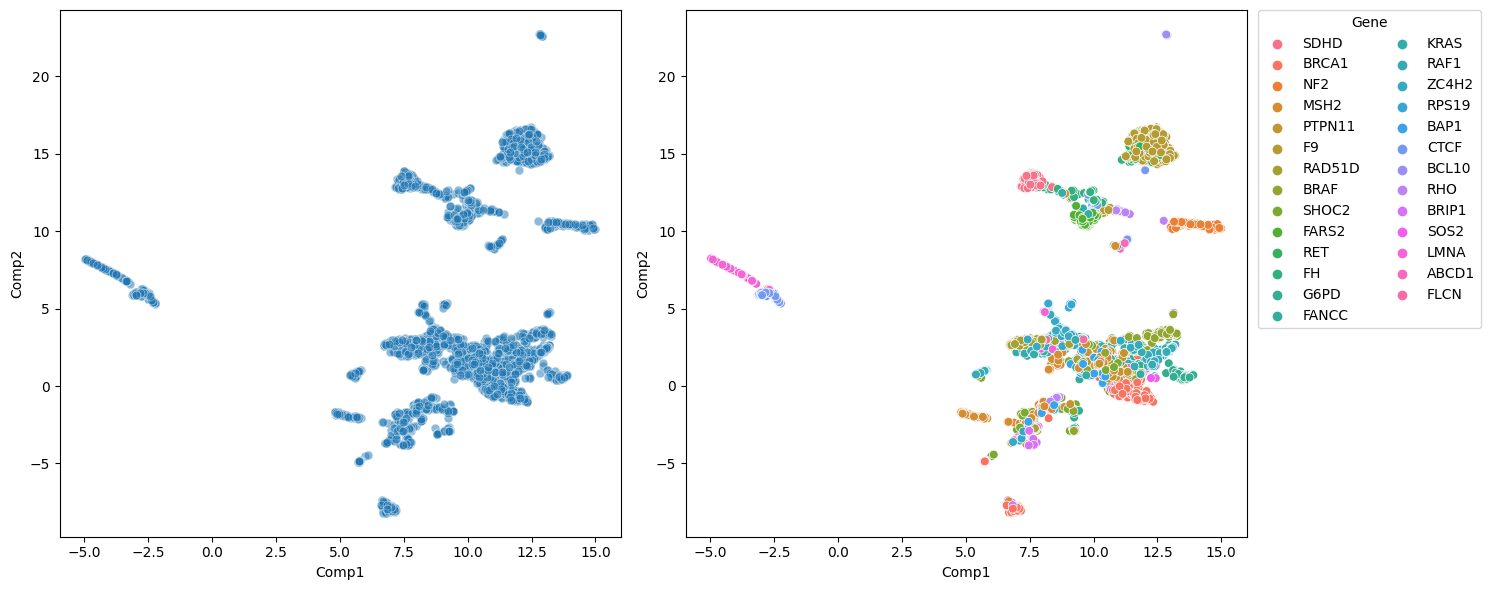

In [29]:
dr_res_df["gene"] = dr_res_df["allele"].apply(lambda x: x.split("_")[0])
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=dr_res_df, alpha=.5,
                x="Comp1", y="Comp2", palette="lightgrey", s=40, ax=ax[0]) ## hue=variant_type, 
sns.scatterplot(data=dr_res_df[dr_res_df["allele"].str.contains("_")], alpha=1,
                x="Comp1", y="Comp2", hue="gene", 
                palette=sns.color_palette("husl", len(dr_res_df["gene"].unique())), s=40, ax=ax[1]) ## hue=variant_type, 
ax[1].legend(ncol=2, title="Gene",
             loc="upper left",
             bbox_to_anchor=(1.02, 1.0),
             borderaxespad=0)

# texts = []
# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
# ax.set_title("UMAP Plot")
# ax.set_xlabel("UMAP1")
# ax.set_ylabel("UMAP2")
plt.tight_layout()
plt.show()

In [4]:
BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"] ## "2024_01_23_Batch_7", "2024_12_09_Batch_11", "2025_03_17_Batch_15"
CLASS_RES_DIR = "../../../../8.2_updated_snakemake_pipeline/outputs/classification_results/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"

feat_importance_local, feat_importance_morph = pl.DataFrame(), pl.DataFrame()
for batch_id in BIO_REP_BATCHES:
    # Read the data
    feat_df = pl.read_csv(f"{CLASS_RES_DIR.format(batch_id)}/feat_importance.csv")
    meta_cols = [c for c in feat_df.columns if c.startswith("Metadata_") or c.startswith("Group") or c == "Batch"]
    feat_cols = [c for c in feat_df.columns if c not in meta_cols]
    feat_df = feat_df.with_columns([
        pl.col(c).cast(pl.Float64) for c in feat_cols
    ])
    feat_df = feat_df.with_columns(
        pl.lit(batch_id).alias("Batch")
    )
    feat_df_local = feat_df.filter(pl.col("Metadata_Protein")).select(meta_cols + [c for c in feat_cols if "GFP" in c])
    feat_df_morph = feat_df.filter(~pl.col("Metadata_Protein")).select(meta_cols + [c for c in feat_cols if "GFP" not in c])
    # display(feat_df_local)
    # display(feat_df_morph)
    
    feat_importance_local = pl.concat([feat_importance_local, feat_df_local], how="diagonal")
    feat_importance_morph = pl.concat([feat_importance_morph, feat_df_morph], how="diagonal")

In [5]:
def plot_top_n_important_feat(df, n=10, ax=None, title=""):
    # Calculate mean and standard deviation for each column
    column_stats = df.agg(['mean', 'std']).T ## [[col for col in df.columns if "GFP" in col]]

    # Sort columns by the sum of mean and std in descending order
    sorted_columns = column_stats.sort_values(by=["mean"], ascending=False)
    sorted_columns = sorted_columns.head(n)
    # display(sorted_columns)

    # Plot mean and std for each column
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(y=sorted_columns.index, width=sorted_columns["mean"], color='skyblue') ## yerr=sorted_columns["std"], capsize=5, edgecolor='black'
    ax.set_yticks(range(len(sorted_columns.index)))
    ax.set_yticklabels(sorted_columns.index, rotation=0, fontsize=10)
    # ax.set_xlabel("Mean")
    ax.set_title(f"Features Importance Mean {title}")
    ax.axvline(x=0.01, color='r', linestyle='--')
    # plt.tight_layout()
    # plt.show()
    return sorted_columns

## 4. Localization change

In [31]:
ref_var_allele_gfp_profile_df = (
    ref_var_cell_gfp_profile_df.group_by(["Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in ref_var_cell_gfp_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)

# ref_var_allele_gfp_profile_df = remove_corr_feats(ref_var_allele_gfp_profile_df)
# ref_var_allele_gfp_profile_df

In [32]:
ref_var_allele_gfp_profile_corr_df = ref_var_allele_gfp_profile_df.select(["Metadata_gene_allele"]+[col for col in ref_var_allele_gfp_profile_df.columns if "Correlation_Correlation" in col])
# ref_var_allele_gfp_profile_corr_df

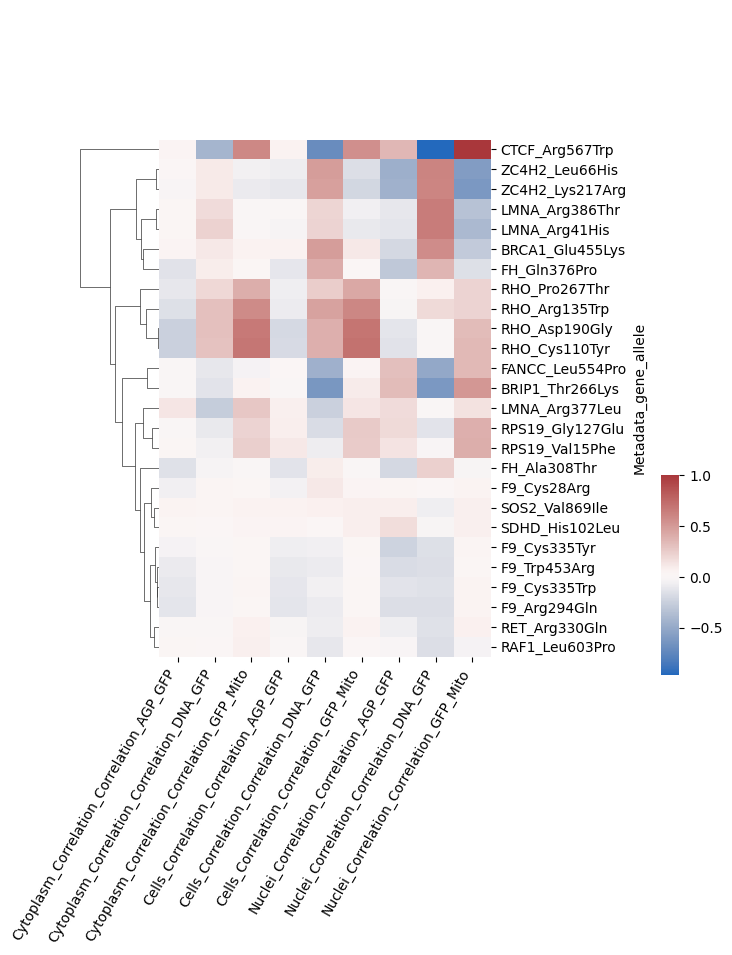

In [33]:
misloc_genes = change_wtvar["localization"].filter((pl.col("Altered_local_both_batches"))).with_columns(
    pl.col("allele_0").str.split("_").list.get(0).alias("gene_symbol")
).unique(subset="gene_symbol")["gene_symbol"]

misloc_variant_corr_diff_df = pd.DataFrame()
for misloc_gene in misloc_genes:
    # fig, axes = plt.subplots(1,1,figsize=(6,5))
    # sns.boxenplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.3, ax=axes,
    #             order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
    # sns.swarmplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes,
    #             order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
    # axes.set_title(misloc_gene)
    ref_var_allele_gfp_profile_corr_df_gene = ref_var_allele_gfp_profile_corr_df.filter(pl.col("Metadata_gene_allele").str.contains(misloc_gene)).to_pandas()
    # display(ref_var_allele_gfp_profile_corr_df_gene)
    misloc_allele_profile_df_nocorr_wt = ref_var_allele_gfp_profile_corr_df_gene[~ref_var_allele_gfp_profile_corr_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
    misloc_allele_profile_df_nocorr_var = ref_var_allele_gfp_profile_corr_df_gene[ref_var_allele_gfp_profile_corr_df_gene["Metadata_gene_allele"].str.contains("_")].copy()
    misloc_allele_profile_df_nocorr_var = ref_var_allele_gfp_profile_corr_df_gene[(ref_var_allele_gfp_profile_corr_df_gene["Metadata_gene_allele"].str.contains("_"))&\
                                                                      ref_var_allele_gfp_profile_corr_df_gene["Metadata_gene_allele"].isin(
                                                                          change_wtvar["localization"].filter((pl.col(f"Altered_local_both_batches")))["allele_0"]
                                                                      )].copy()
    misloc_allele_profile_df_nocorr_var["Gene"] = misloc_allele_profile_df_nocorr_var["Metadata_gene_allele"].apply(lambda x: x.split("_")[0])

    misloc_allele_var_minus_wt = pd.DataFrame()
    for gene, group in misloc_allele_profile_df_nocorr_var.groupby("Gene"):
        # print(gene)
        # display(misloc_allele_profile_df_nocorr_wt.loc[gene])
        group = group.set_index("Metadata_gene_allele").drop("Gene", axis=1).copy()
        g_col = group.columns
        # display(group)
        group = group - misloc_allele_profile_df_nocorr_wt.loc[gene]
        # display(misloc_allele_profile_df_nocorr_wt.loc[[gene]])
        misloc_allele_var_minus_wt = pd.concat([misloc_allele_var_minus_wt, group], axis=0)
        # display(misloc_allele_var_minus_wt)

    # display(misloc_allele_var_minus_wt)
    # print(misloc_allele_var_minus_wt.shape[0])
    # print(misloc_allele_var_minus_wt.shape[0])
    misloc_variant_corr_diff_df = pd.concat([misloc_variant_corr_diff_df, misloc_allele_var_minus_wt])
    

# fig, ax = plt.subplots(1,1)
g = sns.clustermap(misloc_variant_corr_diff_df, cmap="vlag", col_cluster=False, row_cluster=True, figsize=(6, 10), cbar_pos=(1., .32, .03, .2))
ax = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60, ha="right", va="top")
# ax=ax,  

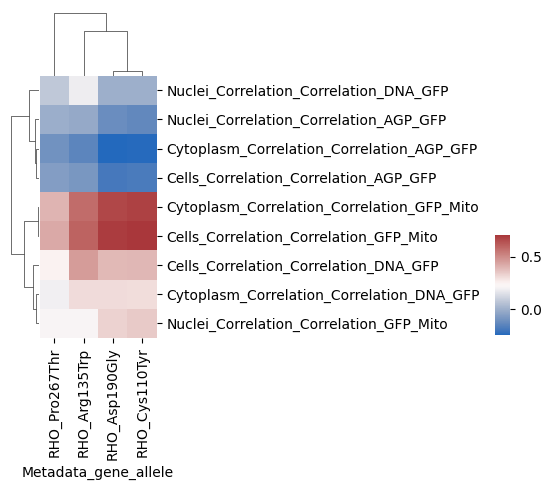

In [37]:
rho_alleles = [x for x in misloc_variant_corr_diff_df.index if "RHO" in x]
g = sns.clustermap(misloc_variant_corr_diff_df.loc[rho_alleles,:].T, cmap="vlag", col_cluster=True, row_cluster=True, figsize=(5, 5), cbar_pos=(1., .32, .03, .2))
# ax = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60, ha="right", va="top")

In [38]:
# Filter out columns where all values are null
non_null_cols_local = [col for col in feat_importance_local.columns if not feat_importance_local[col].is_null().all()]
feat_local_clean_df = feat_importance_local.select(non_null_cols_local)

# Group by "Group1" and "Group2" and compute the mean for all columns except "batch"
feat_local_df_mean = feat_local_clean_df.group_by(["Group1", "Group2"]).agg( ## , "batch"
    pl.col("*").exclude(["Group1", "Group2", "batch"]).mean()
)

# Filter out columns where any values are null
local_cols = [col for col in feat_local_df_mean.columns if "GFP" in col]

,Group1,Group2,Metadata_Protein,Metadata_Control,Cytoplasm_Texture_InfoMeas1_GFP_5_02_256,Nuclei_Texture_Correlation_GFP_5_00_256,Nuclei_RadialDistribution_RadialCV_GFP_8of10,Cytoplasm_Intensity_MaxIntensity_GFP,Nuclei_RadialDistribution_FracAtD_GFP_7of10,Nuclei_RadialDistribution_MeanFrac_GFP_1of10,...,Cytoplasm_Location_CenterMassIntensity_Y_GFP,Nuclei_RadialDistribution_RadialCV_GFP_7of10,Nuclei_RadialDistribution_FracAtD_GFP_10of10,Nuclei_Texture_SumAverage_GFP_20_02_256,Cytoplasm_Texture_InfoMeas2_GFP_20_00_256,Nuclei_Texture_DifferenceVariance_GFP_20_01_256,Cytoplasm_Location_CenterMassIntensity_X_GFP,Nuclei_Texture_SumAverage_GFP_5_03_256,Cytoplasm_Texture_AngularSecondMoment_GFP_20_01_256,Allele
0,SDHD,SDHD_SDHD_Ser68Gly,1.0,0.0,0.012942,0.007099,0.008498,0.010471,0.005558,0.005779,...,0.009188,0.006553,0.006093,0.007337,0.005984,0.007919,0.008530,0.007960,0.007349,SDHD_Ser68Gly
1,SDHD,SDHD_SDHD_Phe34Cys,1.0,0.0,0.010270,0.005670,0.006056,0.011035,0.005915,0.005850,...,0.008950,0.006180,0.006599,0.005613,0.006871,0.006315,0.008464,0.010978,0.007184,SDHD_Phe34Cys
2,SDHD,SDHD_SDHD_His102Leu,1.0,0.0,0.010772,0.004772,0.009618,0.008794,0.011016,0.007078,...,0.008709,0.009426,0.023029,0.007584,0.004461,0.004918,0.005593,0.007234,0.009019,SDHD_His102Leu
3,SDHD,SDHD_SDHD_His102Pro,1.0,0.0,0.008142,0.005793,0.007069,0.010366,0.006118,0.005708,...,0.008705,0.005456,0.007251,0.006446,0.007233,0.007460,0.009172,0.016260,0.006643,SDHD_His102Pro
4,SDHD,SDHD_SDHD_Leu139Arg,1.0,0.0,0.006573,0.007542,0.006025,0.017612,0.005382,0.005314,...,0.005245,0.005657,0.005898,0.006100,0.006967,0.006718,0.007044,0.014501,0.010851,SDHD_Leu139Arg


,Group1,Group2,Metadata_Protein,Metadata_Control,Cytoplasm_Texture_InfoMeas1_GFP_5_02_256,Nuclei_Texture_Correlation_GFP_5_00_256,Nuclei_RadialDistribution_RadialCV_GFP_8of10,Cytoplasm_Intensity_MaxIntensity_GFP,Nuclei_RadialDistribution_FracAtD_GFP_7of10,Nuclei_RadialDistribution_MeanFrac_GFP_1of10,...,Cytoplasm_Location_CenterMassIntensity_Y_GFP,Nuclei_RadialDistribution_RadialCV_GFP_7of10,Nuclei_RadialDistribution_FracAtD_GFP_10of10,Nuclei_Texture_SumAverage_GFP_20_02_256,Cytoplasm_Texture_InfoMeas2_GFP_20_00_256,Nuclei_Texture_DifferenceVariance_GFP_20_01_256,Cytoplasm_Location_CenterMassIntensity_X_GFP,Nuclei_Texture_SumAverage_GFP_5_03_256,Cytoplasm_Texture_AngularSecondMoment_GFP_20_01_256,Allele
0,FARS2,FARS2_FARS2_Thr246Met,1.0,0.0,0.006616,0.005692,0.006292,0.014983,0.006313,0.006136,...,0.008245,0.006218,0.005543,0.006248,0.006267,0.007690,0.007153,0.007330,0.007663,FARS2_Thr246Met
1,FARS2,FARS2_FARS2_Arg419Cys,1.0,0.0,0.006561,0.006318,0.006528,0.014342,0.006393,0.005618,...,0.007144,0.005333,0.005547,0.004345,0.006547,0.006189,0.010205,0.006173,0.006247,FARS2_Arg419Cys
2,FARS2,FARS2_FARS2_Gly3Val,1.0,0.0,0.007393,0.006684,0.005764,0.009134,0.008845,0.006365,...,0.006008,0.005245,0.009627,0.006585,0.006032,0.006439,0.007187,0.006128,0.006852,FARS2_Gly3Val
3,FARS2,FARS2_FARS2_Tyr144Cys,1.0,0.0,0.006444,0.005933,0.006405,0.009422,0.006488,0.006463,...,0.007325,0.005922,0.005895,0.008577,0.006349,0.008549,0.006737,0.006369,0.008362,FARS2_Tyr144Cys
4,FARS2,FARS2_FARS2_Ile388Ser,1.0,0.0,0.007674,0.005691,0.006162,0.013965,0.007329,0.005986,...,0.004877,0.005558,0.006463,0.004460,0.004848,0.006367,0.008390,0.012045,0.006218,FARS2_Ile388Ser


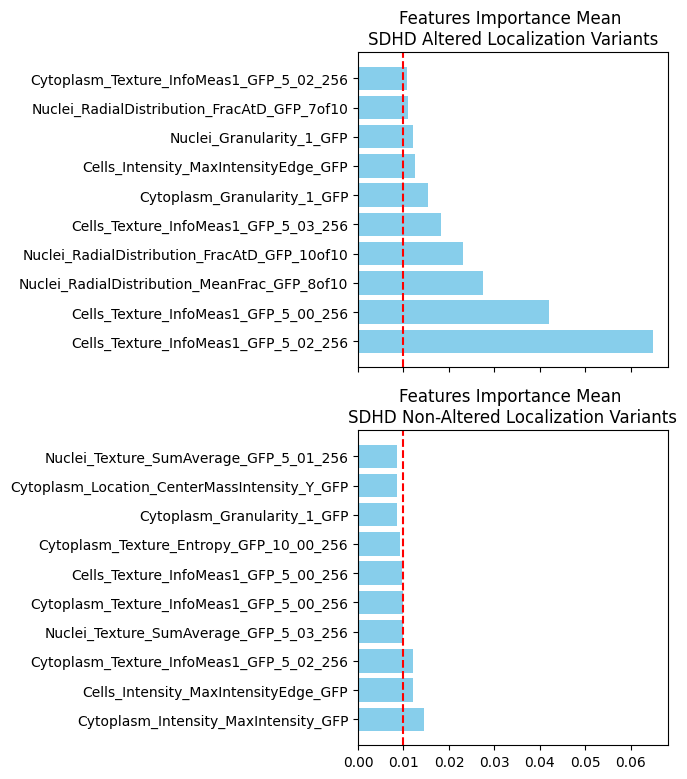

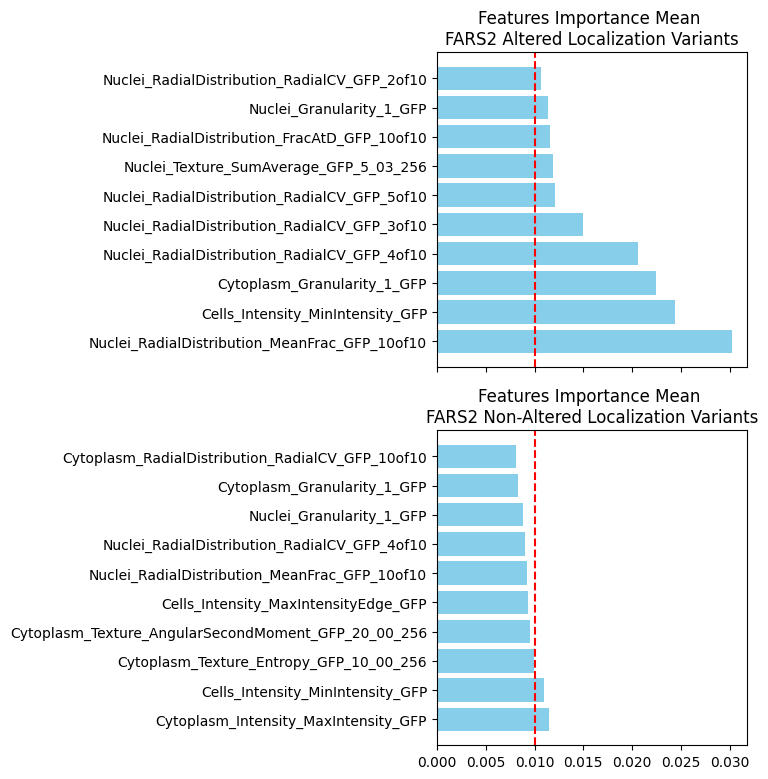

In [39]:
for gene in misloc_genes.to_list()+["FARS2"]:
    feat_df_mean_gene = feat_local_df_mean.select(meta_cols+local_cols).filter(
        pl.col("Group1").str.contains(gene)
    )
    if gene != "FARS2":
        morph_altered_alleles = change_wtvar["localization"].filter(
            (pl.col("Altered_local_both_batches"))&(pl.col("allele_0").str.contains(gene))
        ).unique("allele_0")
        morph_ctrl_alleles = change_wtvar["localization"].filter(
            (~pl.col("Altered_local_both_batches"))&(pl.col("allele_0").str.contains(gene))
        ).unique("allele_0")
    else:
        morph_altered_alleles = change_wtvar["localization"].filter(
            (pl.col("Altered_local_batch14")==1)&(pl.col("allele_0").str.contains(gene))
        ).unique("allele_0")
        morph_ctrl_alleles = change_wtvar["localization"].filter(
            (pl.col("Altered_local_batch14")==0)&(pl.col("allele_0").str.contains(gene))
        ).unique("allele_0")

    feat_df_mean_pd = feat_df_mean_gene.to_pandas()
    feat_df_mean_pd["Allele"] = feat_df_mean_pd["Group2"].apply(lambda x: '_'.join(x.split("_")[1:]) if "_" in x else x)
    if gene == "FARS2" or gene == "SDHD":
        display(feat_df_mean_pd.head())

    feat_df_mean_pd_misloc_var = feat_df_mean_pd[feat_df_mean_pd["Allele"].isin(morph_altered_alleles["allele_0"].unique())]
    feat_df_mean_pd_no_misloc_var = feat_df_mean_pd[feat_df_mean_pd["Allele"].isin(morph_ctrl_alleles["allele_0"].unique())]

    if gene == "FARS2" or gene == "SDHD":
        # display(feat_df_mean_pd_misloc_var)
        fig, axes = plt.subplots(2,1, figsize=(4, 9), sharex=True)
        feat_import_misloc_var = plot_top_n_important_feat(feat_df_mean_pd_misloc_var.drop(
            ["Group1","Group2","Metadata_Protein","Metadata_Control","Allele"], axis=1
        ), ax=axes[0], title=f"\n{gene} Altered Localization Variants")
        feat_import_no_misloc_var = plot_top_n_important_feat(feat_df_mean_pd_no_misloc_var.drop(
            ["Group1","Group2","Metadata_Protein","Metadata_Control","Allele"], axis=1
        ), ax=axes[1], title=f"\n{gene} Non-Altered Localization Variants")

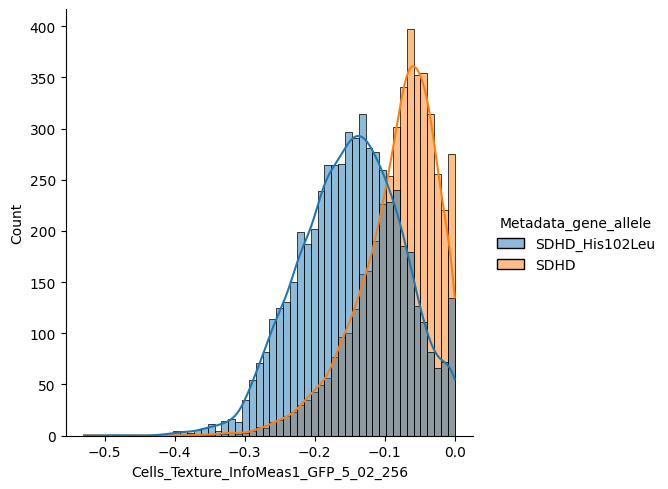

In [ ]:
sns.displot(
    data=ref_var_cell_gfp_profile_df.filter((pl.col("Metadata_gene_allele")=="SDHD")|(pl.col("Metadata_gene_allele")=="SDHD_His102Leu")).to_pandas(),
    x="Cells_Texture_InfoMeas1_GFP_5_02_256", hue="Metadata_gene_allele", kde=True
)

In [ ]:
ref_var_allele_gfp_profile_df

var_wt_diff_gfp_df = pl.DataFrame()
for misloc_gene in misloc_genes:
    # fig, axes = plt.subplots(1,1,figsize=(6,5))
    # sns.boxenplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.3, ax=axes,
    #             order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
    # sns.swarmplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes,
    #             order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
    # axes.set_title(misloc_gene)
    ref_var_allele_gfp_profile_df_gene = ref_var_allele_gfp_profile_df.filter(pl.col("Metadata_gene_allele").str.contains(misloc_gene)).to_pandas()
    # display(ref_var_allele_gfp_profile_corr_df_gene)
    misloc_allele_profile_df_wt = ref_var_allele_gfp_profile_df_gene[~ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
    misloc_allele_profile_df_var = ref_var_allele_gfp_profile_df_gene[(ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].str.contains("_"))&\
                                                                      ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].isin(
                                                                          change_wtvar["localization"].filter((pl.col(f"Altered_local_both_batches")))["allele_0"]
                                                                      )].copy()
    misloc_allele_profile_df_var["Metadata_Gene"] = misloc_allele_profile_df_var["Metadata_gene_allele"].apply(lambda x: x.split("_")[0])
    display(misloc_allele_profile_df_var)
    var_wt_diff_gfp_df = pl.concat([var_wt_diff_gfp_df, pl.DataFrame(misloc_allele_profile_df_var)])
    # break

,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
2,RPS19_Val15Phe,0.351892,0.378026,0.837427,1.0,1.0,1.0,1.0,0.988339,1.0,...,0.873825,0.278079,0.250801,0.261343,0.249898,0.796671,0.802053,0.796231,0.800478,RPS19
3,RPS19_Gly127Glu,0.315102,0.338748,0.810963,1.0,1.0,1.0,1.0,0.995023,1.0,...,0.430895,0.195388,0.137146,0.208273,0.164073,0.416663,0.419113,0.404595,0.427529,RPS19


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
7,ZC4H2_Leu66His,0.363305,0.375663,0.579105,1.0,1.0,1.0,0.99997,0.961078,1.0,...,29.850605,11.919512,10.386845,12.386182,10.687500,26.820449,26.894309,26.501613,27.128555,ZC4H2
8,ZC4H2_Lys217Arg,0.336141,0.368558,0.541876,1.0,1.0,1.0,1.00000,0.899234,1.0,...,1.117101,0.819243,0.710208,0.796093,0.716324,1.039616,1.035405,1.051532,1.047205,ZC4H2


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
5,CTCF_Arg567Trp,0.239687,0.315934,0.883946,1.0,1.0,1.0,1.0,0.998734,1.0,...,0.772451,0.244646,0.202741,0.239686,0.234375,0.749487,0.762605,0.727647,0.730171,CTCF


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
7,RET_Arg330Gln,0.276089,0.297984,0.854293,1.0,1.0,1.0,0.999927,0.998759,1.0,...,14.299375,7.373886,7.254193,7.578447,7.087806,13.248061,13.151409,13.16758,13.258164,RET


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
9,RAF1_Leu603Pro,0.367105,0.216673,0.726729,1.0,1.0,1.0,1.0,1.0,1.0,...,0.592273,0.49747,0.498606,0.502483,0.494632,0.538864,0.541083,0.54645,0.544508,RAF1


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
17,SDHD_His102Leu,0.096708,0.243326,0.928502,1.0,1.0,1.0,1.0,0.976827,1.0,...,1.131537,0.776791,0.921263,0.776944,0.937648,1.014217,1.020685,1.014751,1.023085,SDHD


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
6,F9_Cys28Arg,0.244453,0.347267,0.840397,1.0,1.0,1.0,1.000000,0.994207,1.000000,...,0.649588,0.423415,0.430659,0.438979,0.447802,0.601237,0.595987,0.592647,0.598089,F9
10,F9_Cys335Trp,0.202519,0.295277,0.846024,1.0,1.0,1.0,0.999558,0.996221,1.000000,...,14.139089,6.471468,6.705122,6.776267,6.807039,12.556605,12.621443,12.522314,12.733264,F9
14,F9_Trp453Arg,0.220157,0.289998,0.842869,1.0,1.0,1.0,1.000000,0.999848,0.991825,...,16.991755,7.975696,7.389810,8.242127,7.970276,15.612874,15.707094,15.847387,15.566089,F9
15,F9_Cys335Tyr,0.271590,0.305014,0.840807,1.0,1.0,1.0,0.999992,0.999721,1.000000,...,21.461469,8.629673,8.627621,8.474904,8.955720,19.515909,19.754179,19.606383,19.324990,F9
55,F9_Arg294Gln,0.189600,0.291693,0.839631,1.0,1.0,1.0,1.000000,0.999798,1.000000,...,17.891323,7.828972,8.355859,8.435442,8.066193,15.893772,16.389603,15.872579,16.438646,F9


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
1,LMNA_Arg386Thr,0.150894,0.762224,0.256170,1.0,1.0,1.0,1.0,0.768878,1.0,...,5.730316,1.748768,1.410215,1.756974,1.425035,5.391375,5.455951,5.351313,5.410071,LMNA
4,LMNA_Arg41His,0.139233,0.809312,0.250973,1.0,1.0,1.0,1.0,0.737710,1.0,...,8.977532,2.869911,2.398141,3.009456,2.391593,8.147091,8.357812,8.218570,8.403444,LMNA
6,LMNA_Arg377Leu,0.246843,0.321562,0.530089,1.0,1.0,1.0,1.0,0.858712,1.0,...,1.424477,0.650576,0.644301,0.648512,0.599229,1.354502,1.355299,1.350602,1.359122,LMNA


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
0,BRIP1_Thr266Lys,0.20204,0.178192,0.556712,0.938602,0.649474,1.0,0.053693,1.0,0.999893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BRIP1


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
1,FH_Ala308Thr,0.197562,0.232273,0.85978,0.915742,1.0,1.0,1.0,0.998650,0.967962,...,0.184126,0.036982,0.023795,0.041407,0.038641,0.187372,0.18947,0.193546,0.187814,FH
3,FH_Gln376Pro,0.204564,0.359190,0.89067,1.000000,1.0,1.0,1.0,0.978711,1.000000,...,2.036787,0.893885,1.000000,0.944045,0.975624,1.883083,1.87041,1.910122,1.867141,FH


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
0,SOS2_Val869Ile,0.259587,0.197336,0.585215,1.0,1.0,1.0,0.999937,0.882084,1.0,...,0.479341,0.337512,0.351252,0.339604,0.336561,0.454575,0.458597,0.452812,0.460247,SOS2


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
3,FANCC_Leu554Pro,0.190817,0.280882,0.787154,1.0,1.0,1.0,1.0,0.972784,1.0,...,0.209354,0.123848,0.160038,0.130177,0.149942,0.200267,0.199966,0.200185,0.199824,FANCC


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
33,BRCA1_Glu455Lys,0.251924,0.282191,0.631789,0.945931,0.95169,1.0,0.40373,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BRCA1


,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,...,Nuclei_Texture_Variance_GFP_10_03_256,Nuclei_Texture_Variance_GFP_20_00_256,Nuclei_Texture_Variance_GFP_20_01_256,Nuclei_Texture_Variance_GFP_20_02_256,Nuclei_Texture_Variance_GFP_20_03_256,Nuclei_Texture_Variance_GFP_5_00_256,Nuclei_Texture_Variance_GFP_5_01_256,Nuclei_Texture_Variance_GFP_5_02_256,Nuclei_Texture_Variance_GFP_5_03_256,Metadata_Gene
1,RHO_Arg135Trp,0.488561,0.330911,0.724174,1.0,1.0,1.0,1.0,0.998578,0.999682,...,0.489428,0.339094,0.327178,0.348013,0.324905,0.449909,0.451415,0.448555,0.451701,RHO
2,RHO_Cys110Tyr,0.395285,0.328599,0.828655,1.0,1.0,1.0,1.0,0.996078,1.000000,...,0.795360,0.403596,0.411399,0.403065,0.392671,0.760417,0.757441,0.757351,0.751466,RHO
3,RHO_Asp190Gly,0.390131,0.331298,0.813465,1.0,1.0,1.0,1.0,0.993938,1.000000,...,0.763162,0.455119,0.457350,0.476733,0.463306,0.700413,0.702796,0.704322,0.710305,RHO
4,RHO_Pro267Thr,0.534377,0.216251,0.545322,1.0,1.0,1.0,1.0,0.998420,1.000000,...,1.208476,0.840610,0.800439,0.877491,0.822427,1.115524,1.116241,1.106926,1.114056,RHO


In [58]:
# var_wt_diff_gfp_df

# fig, ax = plt.subplots(1,1,figsize=(6,6))
# plot_dr(var_wt_diff_gfp_df, "umap", ax=ax, 
#         dr_args={"n_neighbors":15, "min_dist":0.1, "n_components":2, "random_state":42, "n_jobs":1}, 
#         plot_args={"hue": "Metadata_Gene"})

## 5. Morphology change

In [76]:
# Filter out columns where all values are null
non_null_cols = [col for col in feat_importance_morph.columns if not feat_importance_morph[col].is_null().all()]
feat_morph_clean_df = feat_importance_morph.select(non_null_cols)

# Group by "Group1" and "Group2" and compute the mean for all columns except "batch"
feat_df_mean = feat_morph_clean_df.group_by(["Group1", "Group2"]).agg( ## , "batch"
    pl.col("*").exclude(["Group1", "Group2", "batch"]).mean()
)

# Filter out columns where any values are null
# meta_cols = [col for col in feat_df_mean.columns if "GFP" not in col]
morph_cols = [col for col in feat_df_mean.columns if "DNA" in col or "AGP" in col or "Mito" in col]
# no_null_morph_cols = [col for col in morph_cols if not feat_df_mean[col].is_null().any()] ## not feat_df_mean[col].is_nan().any() and 

# feat_df_mean = feat_df_mean.select(meta_cols+morph_cols).with_columns(
#     pl.when(pl.col("Group1").is_in(ctrl_alleles_flat))
#     .then(pl.lit("Control"))
#     .otherwise(pl.lit("Allele"))
#     .alias("Variant_Type")
# )

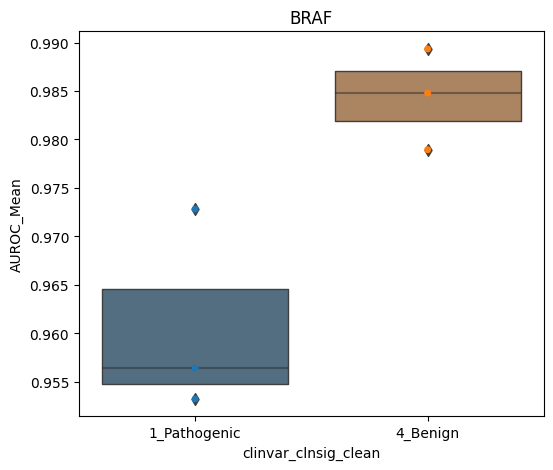

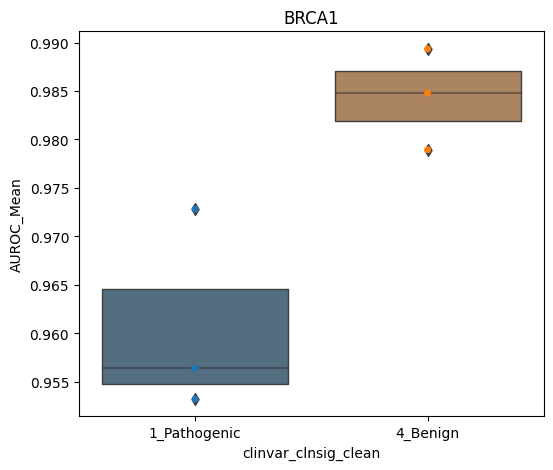

In [ ]:
alter_morph_genes = change_wtvar["morphology"].filter((pl.col("Altered_morph_both_batches"))).with_columns(
    pl.col("allele_0").str.split("_").list.get(0).alias("gene_symbol")
).unique(subset="gene_symbol")["gene_symbol"]
alter_morph_alleles = change_wtvar["morphology"].filter((pl.col("Altered_morph_both_batches")))["allele_0"].unique()

# for misloc_gene in alter_morph_genes:
#     fig, axes = plt.subplots(1,1,figsize=(6,5))
#     sns.boxenplot(data=change_wtvar["morphology"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
#                   x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.3, ax=axes,
#                   order=sorted(change_wtvar["morphology"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
#     sns.swarmplot(data=change_wtvar["morphology"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
#                   x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes,
#                   order=sorted(change_wtvar["morphology"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
#     axes.set_title(misloc_gene)

for misloc_gene in alter_morph_genes:
    fig, axes = plt.subplots(1,1,figsize=(6,5))
    # sns.boxenplot(data=change_wtvar["morphology"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").is_in(alter_morph_alleles)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.3, ax=axes,
    #               order=sorted(change_wtvar["morphology"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").is_in(alter_morph_alleles)).to_pandas()["clinvar_clnsig_clean"].unique()))
    sns.swarmplot(data=change_wtvar["morphology"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").is_in(alter_morph_alleles)).to_pandas(), 
                  x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes,
                  order=sorted(change_wtvar["morphology"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").is_in(alter_morph_alleles)).to_pandas()["clinvar_clnsig_clean"].unique()))
    axes.set_title(misloc_gene)

,Group1,Group2,Metadata_Protein,Metadata_Control,Nuclei_Granularity_6_Mito,Nuclei_Texture_SumVariance_Mito_20_03_256,Cells_RadialDistribution_RadialCV_AGP_7of10,Nuclei_Texture_InfoMeas2_Mito_5_00_256,Cells_RadialDistribution_RadialCV_Mito_10of10,Cytoplasm_RadialDistribution_RadialCV_DNA_3of10,...,Cytoplasm_Texture_SumVariance_DNA_20_00_256,Nuclei_Texture_SumVariance_AGP_20_00_256,Nuclei_Texture_DifferenceVariance_AGP_10_01_256,Nuclei_Texture_DifferenceEntropy_Mito_10_03_256,Cytoplasm_Texture_InfoMeas1_DNA_20_01_256,Cytoplasm_Correlation_K_DNA_AGP,Cells_Texture_Correlation_Mito_5_03_256,Cytoplasm_Texture_DifferenceVariance_AGP_5_03_256,Cells_Texture_AngularSecondMoment_AGP_20_02_256,Allele
0,BRCA1,BRCA1_BRCA1_Leu660Pro,0.0,0.0,0.000558,0.000977,0.000846,0.000009,0.000866,0.000422,...,0.002530,0.000000,0.003937,0.000540,0.000648,0.001288,0.000266,0.001715,0.000086,BRCA1_Leu660Pro
1,BRCA1,BRCA1_BRCA1_Ala102Gly,0.0,0.0,0.000816,0.001123,0.001496,0.000680,0.001119,0.000736,...,0.000651,0.000796,0.001042,0.001641,0.002810,0.002016,0.000207,0.000383,0.001117,BRCA1_Ala102Gly
2,BRCA1,BRCA1_BRCA1_Cys44Tyr,0.0,0.0,0.000726,0.001367,0.000893,0.001121,0.001099,0.000615,...,0.000196,0.000101,0.001786,0.000000,0.002846,0.000096,0.000190,0.000065,0.000837,BRCA1_Cys44Tyr
3,BRCA1,BRCA1_BRCA1_Cys61Gly,0.0,0.0,0.000570,0.000478,0.000476,0.001727,0.000651,0.000585,...,0.000438,0.001275,0.000195,0.001921,0.000629,0.000649,0.000677,0.000467,0.000907,BRCA1_Cys61Gly
4,BRCA1,BRCA1_BRCA1_Cys64Ser,0.0,0.0,0.001530,0.000358,0.001008,0.000546,0.001220,0.001053,...,0.000340,0.000133,0.000385,0.000294,0.001079,0.000587,0.001050,0.000462,0.001694,BRCA1_Cys64Ser


,Group1,Group2,Metadata_Protein,Metadata_Control,Nuclei_Granularity_6_Mito,Nuclei_Texture_SumVariance_Mito_20_03_256,Cells_RadialDistribution_RadialCV_AGP_7of10,Nuclei_Texture_InfoMeas2_Mito_5_00_256,Cells_RadialDistribution_RadialCV_Mito_10of10,Cytoplasm_RadialDistribution_RadialCV_DNA_3of10,...,Cytoplasm_Texture_SumVariance_DNA_20_00_256,Nuclei_Texture_SumVariance_AGP_20_00_256,Nuclei_Texture_DifferenceVariance_AGP_10_01_256,Nuclei_Texture_DifferenceEntropy_Mito_10_03_256,Cytoplasm_Texture_InfoMeas1_DNA_20_01_256,Cytoplasm_Correlation_K_DNA_AGP,Cells_Texture_Correlation_Mito_5_03_256,Cytoplasm_Texture_DifferenceVariance_AGP_5_03_256,Cells_Texture_AngularSecondMoment_AGP_20_02_256,Allele
0,BRAF,BRAF_BRAF_Glu501Val,0.0,0.0,0.001217,0.001060,0.000820,0.001315,0.001694,0.000981,...,0.002343,0.000335,0.002613,0.002584,0.002245,0.000222,0.001085,0.000193,0.000011,BRAF_Glu501Val
1,BRAF,BRAF_BRAF_Val487Gly,0.0,0.0,0.001237,0.000511,0.000701,0.000987,0.002637,0.001493,...,0.000388,0.000050,0.000983,0.000318,0.000505,0.003022,0.001173,0.000674,0.001841,BRAF_Val487Gly
2,BRAF,BRAF_BRAF_Gly469Glu,0.0,0.0,0.000760,0.000492,0.000344,0.001086,0.001030,0.000461,...,0.000998,0.000753,0.000575,0.001757,0.001321,0.001140,0.000904,0.006785,0.004317,BRAF_Gly469Glu
3,BRAF,BRAF_BRAF_Phe468Ser,0.0,0.0,0.002000,0.000466,0.001074,0.002011,0.000569,0.000327,...,0.000523,0.000000,0.001500,0.000126,0.002962,0.000879,0.000249,0.001647,0.000489,BRAF_Phe468Ser
4,BRAF,BRAF_BRAF_Gly464Val,0.0,0.0,0.001255,0.000343,0.000348,0.005366,0.001202,0.000655,...,0.000632,0.000140,0.000777,0.000761,0.001662,0.001473,0.000678,0.003071,0.000169,BRAF_Gly464Val


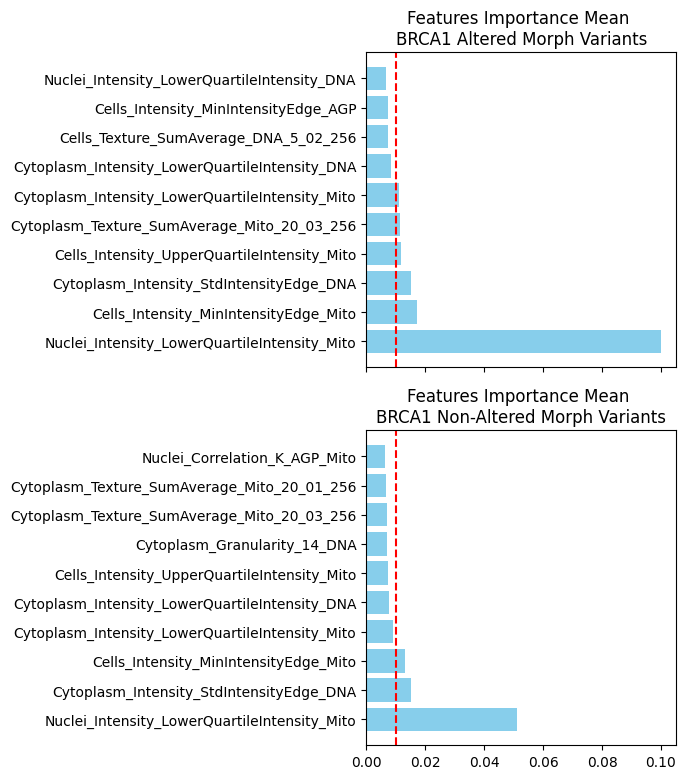

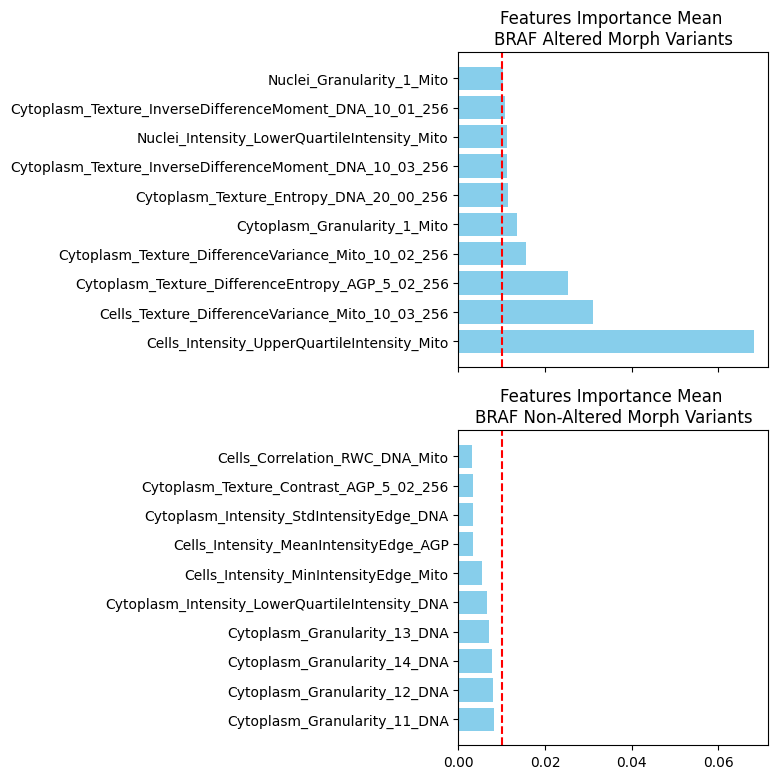

In [ ]:
for gene in ["BRCA1","BRAF"]:
    feat_df_mean_gene = feat_df_mean.select(meta_cols+morph_cols).filter(
        pl.col("Group1").str.contains(gene)
    )
    morph_altered_alleles = change_wtvar["morphology"].filter(
        (pl.col("Altered_morph_both_batches"))&(pl.col("allele_0").str.contains(gene))
    ).unique("allele_0")
    morph_ctrl_alleles = change_wtvar["morphology"].filter(
        (~pl.col("Altered_morph_both_batches"))&(pl.col("allele_0").str.contains(gene))
    ).unique("allele_0")

    feat_df_mean_pd = feat_df_mean_gene.to_pandas()
    feat_df_mean_pd["Allele"] = feat_df_mean_pd["Group2"].apply(lambda x: '_'.join(x.split("_")[1:]) if "_" in x else x)
    display(feat_df_mean_pd.head())

    feat_df_mean_pd_misloc_var = feat_df_mean_pd[feat_df_mean_pd["Allele"].isin(morph_altered_alleles["allele_0"].unique())]
    feat_df_mean_pd_no_misloc_var = feat_df_mean_pd[feat_df_mean_pd["Allele"].isin(morph_ctrl_alleles["allele_0"].unique())]

    # display(feat_df_mean_pd_misloc_var)
    fig, axes = plt.subplots(2,1, figsize=(4, 9), sharex=True)
    feat_import_misloc_var = plot_top_n_important_feat(feat_df_mean_pd_misloc_var.drop(
        ["Group1","Group2","Metadata_Protein","Metadata_Control","Allele"], axis=1
    ), ax=axes[0], title=f"\n{gene} Altered Morph Variants")
    feat_import_no_misloc_var = plot_top_n_important_feat(feat_df_mean_pd_no_misloc_var.drop(
        ["Group1","Group2","Metadata_Protein","Metadata_Control","Allele"], axis=1
    ), ax=axes[1], title=f"\n{gene} Non-Altered Morph Variants")

In [ ]:
brca1_morph_vars = change_wtvar["morphology"].filter((pl.col("Altered_morph_both_batches"))&(pl.col("allele_0").str.contains("BRCA1")))["allele_0"].unique()
# change_wtvar["morphology"].filter(pl.col("Altered_morph_both_batches")).unique("allele_0")

sns.kdeplot(
    data=ref_var_cell_morph_profile_df.filter((pl.col("Metadata_gene_allele")=="BRCA1")|(pl.col("Metadata_gene_allele").is_in(brca1_morph_vars))).to_pandas().sort_values(by="Metadata_gene_allele"),
    x="Nuclei_Intensity_LowerQuartileIntensity_Mito", hue="Metadata_gene_allele", log_scale=(True,False)
)

<Axes: xlabel='Cells_Intensity_UpperQuartileIntensity_Mito', ylabel='Density'>

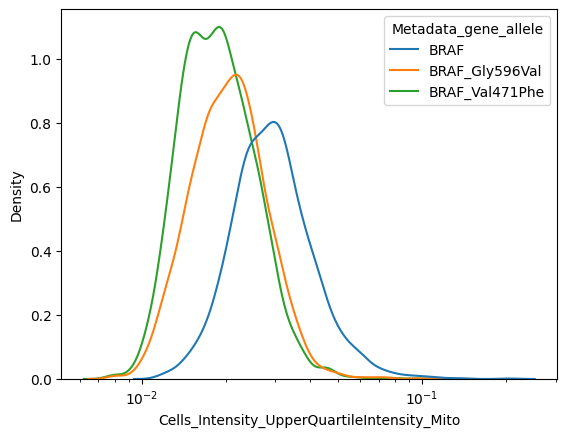

In [44]:
brca1_morph_vars = change_wtvar["morphology"].filter((pl.col("Altered_morph_both_batches"))&(pl.col("allele_0").str.contains("BRAF")))["allele_0"].unique()
# change_wtvar["morphology"].filter(pl.col("Altered_morph_both_batches")).unique("allele_0")

sns.kdeplot(
    data=ref_var_cell_morph_profile_df.filter((pl.col("Metadata_gene_allele")=="BRAF")|(pl.col("Metadata_gene_allele").is_in(brca1_morph_vars))).to_pandas().sort_values(by="Metadata_gene_allele"),
    x="Cells_Intensity_UpperQuartileIntensity_Mito", hue="Metadata_gene_allele", log_scale=(True,False)
)